##Time Series Forecasting for Sales and Revenue Optimization Using ARIMA in Python

#Import librraies and dataset

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/content/superstore_final_dataset (1).csv', encoding = 'windows-1252')
df.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales
0,1,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/6/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680


#Data description

In [5]:
df.isnull().sum()

,0
Row_ID,0
Order_ID,0
Order_Date,0
Ship_Date,0
Ship_Mode,0
Customer_ID,0
Customer_Name,0
Segment,0
Country,0
City,0


#Null values checking and removing

In [6]:
df = df.dropna()
df.isnull().sum()

,0
Row_ID,0
Order_ID,0
Order_Date,0
Ship_Date,0
Ship_Mode,0
Customer_ID,0
Customer_Name,0
Segment,0
Country,0
City,0


# Converting Order_Date to datetime


In [7]:
df["Order_Date"] = pd.to_datetime(df["Order_Date"], dayfirst=True)

# Aggregating sales data by month


In [8]:
df_monthly = df.groupby(df["Order_Date"].dt.to_period("M")).agg({"Sales": "sum"}).reset_index()
df_monthly["Order_Date"] = df_monthly["Order_Date"].dt.to_timestamp()

# 🔵 INTERACTIVE SALES TREND PLOT


In [9]:
fig = px.line(df_monthly, x="Order_Date", y="Sales", title="📊 Monthly Sales Trends", markers=True)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Sales ($)")
fig.show()

# 🔥 SALES DISTRIBUTION PLOT


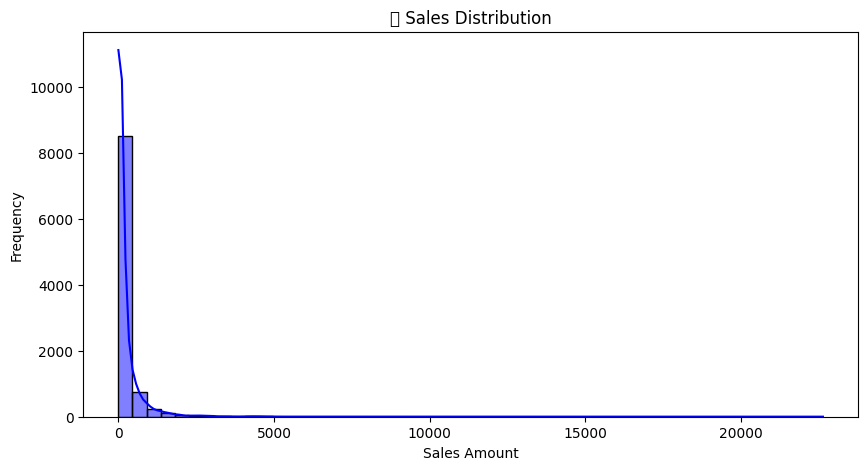

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Sales"], kde=True, bins=50, color="blue")
plt.title("📊 Sales Distribution")
plt.xlabel("Sales Amount")
plt.ylabel("Frequency")
plt.show()

# 🔥 SALES BY CATEGORY


In [11]:
fig = px.bar(df.groupby("Category")["Sales"].sum().reset_index(),
             x="Category", y="Sales", title="📌 Sales by Category", color="Category")
fig.show()

# 🔥 SALES BY SUB-CATEGORY


In [12]:
fig = px.bar(df.groupby("Sub_Category")["Sales"].sum().reset_index().sort_values("Sales"),
             x="Sales", y="Sub_Category", title="📌 Sales by Sub-Category", color="Sales", orientation="h")
fig.show()

# 🔥 HEATMAP: MONTHLY SALES PATTERN


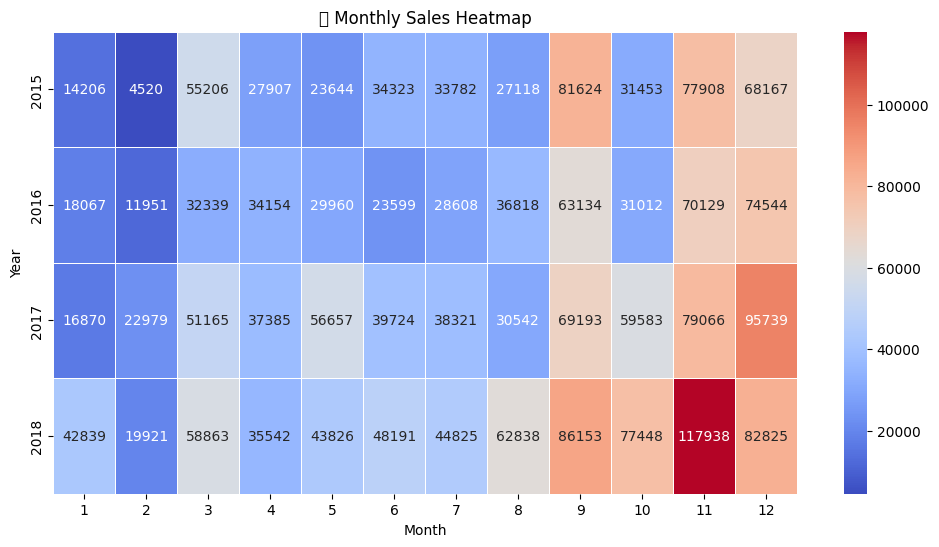

In [13]:
df["Year"] = df["Order_Date"].dt.year
df["Month"] = df["Order_Date"].dt.month
sales_pivot = df.pivot_table(index="Year", columns="Month", values="Sales", aggfunc="sum")

plt.figure(figsize=(12, 6))
sns.heatmap(sales_pivot, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)
plt.title("🔥 Monthly Sales Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# ACF & PACF Plots for ARIMA Model Order Selection


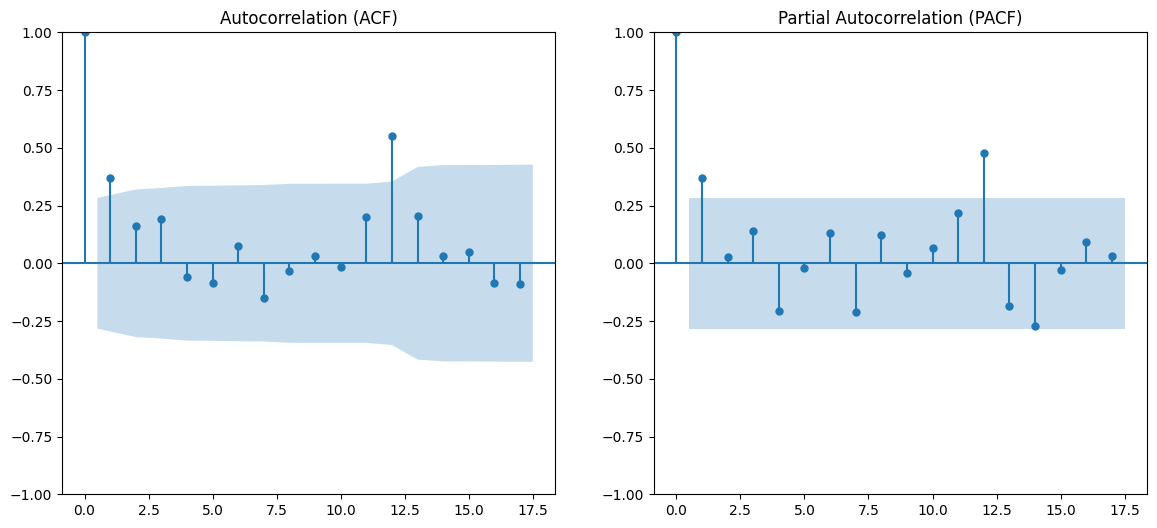

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(df_monthly["Sales"], ax=ax[0], title="Autocorrelation (ACF)")
plot_pacf(df_monthly["Sales"], ax=ax[1], title="Partial Autocorrelation (PACF)")
plt.show()

# Train-Test Split (80% train, 20% test)


In [15]:
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly["Sales"][:train_size], df_monthly["Sales"][train_size:]

# Auto-Select ARIMA Order (p, d, q)


In [16]:
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
best_order = auto_model.order
print(f"Optimal ARIMA Order: {best_order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=928.258, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=886.198, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=913.119, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=884.672, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=882.993, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=884.979, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=882.135, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=880.237, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=879.595, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=881.008, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=911.752, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=874.845, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=872.667, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=872.764, 

# Training ARIMA Model with Best Order


In [17]:
arima_model = ARIMA(train, order=best_order)
arima_model_fit = arima_model.fit()

# Forecasting Future Sales


In [18]:
arima_forecast = arima_model_fit.forecast(steps=len(test))

# Interactive Forecast Plot using Plotly


In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_monthly["Order_Date"], y=df_monthly["Sales"],
                         mode="lines+markers", name="Actual Sales", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=df_monthly["Order_Date"][train_size:], y=arima_forecast,
                         mode="lines+markers", name="ARIMA Forecast", line=dict(color="red")))

fig.update_layout(title="📈 Sales Forecast with ARIMA",
                  xaxis_title="Date", yaxis_title="Sales ($)",
                  legend=dict(x=0, y=1))

fig.show()

#  ARIMA Model Performance


In [20]:
mae = mean_absolute_error(test, arima_forecast)
rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"📊 ARIMA Model Performance: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

📊 ARIMA Model Performance: MAE = 25671.95, RMSE = 34154.17
